# Q1: Computes permitted detached ADU additions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import os

from dateutil.relativedelta import relativedelta

tqdm.pandas()

In [2]:
import glob

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')

In [4]:
dADU_permits = pd.read_csv(
    os.path.join(OUTPUT_FP, 'IssuedADUs', 'Adu_Detach.csv'), dtype={'APN': str}, parse_dates=['DATE'])

## Compute average time from permit issuance to completion 

In [5]:
soc_df = pd.DataFrame()
soc_files = glob.glob(os.path.join(INPUT_FP, 'SOC', r'soc[0-9]*.csv'))

for file in soc_files:
    year = '20' + file.split(os.path.sep)[-1].replace('soc', '').replace('.csv', '')
    soc_year = pd.read_csv(file)
    soc_year['survey_year'] = year
    soc_df = pd.concat([soc_df, soc_year])

In [6]:
soc_files

['/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/inputs/SOC/soc17.csv',
 '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/inputs/SOC/soc18.csv',
 '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/inputs/SOC/soc20.csv',
 '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/inputs/SOC/soc19.csv',
 '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/inputs/SOC/soc16.csv',
 '/oak/stanford/groups/deho/building_compliance/outputs/Population-Estimates/inputs/SOC/soc15.csv']

In [7]:
# Filter to Pacific division
soc_df = soc_df.loc[soc_df['DIV'] == 9]

In [8]:
# Dates (start date, construction date, completion date)

# As the survey includes single-family houses started, completed and/or sold in the US, some
# observations have missing start or completion dates, coded as 0

# Replace these 0 values with None 
soc_df['STRT'] = soc_df['STRT'].replace(0, np.nan)
soc_df['COMP'] = soc_df['COMP'].replace(0, np.nan)

# * Check that all dates are 6 characters YYYYMM
#assert len(soc_df['STRT'].apply(lambda y: len(str(y))).unique()) == 1
#assert len(soc_df['COMP'].apply(lambda y: len(str(y))).unique()) == 1
assert len(soc_df['AUTH'].apply(lambda y: len(str(y))).unique()) == 1

soc_df['permit_date'] = pd.to_datetime(soc_df['AUTH'], format='%Y%m')
soc_df['start_date'] = pd.to_datetime(soc_df['STRT'], format='%Y%m')
soc_df['completion_date'] = pd.to_datetime(soc_df['COMP'], format='%Y%m')

In [9]:
# Time from permit to completion
soc_df['permit_comp_delta'] = (soc_df['completion_date'] - soc_df['permit_date'])/np.timedelta64(1, 'M')

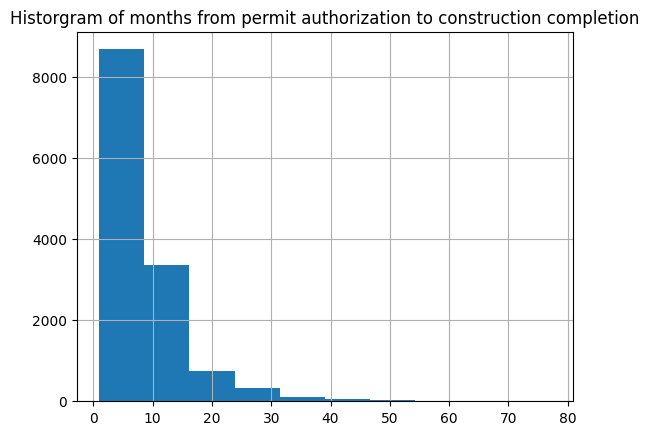

In [10]:
soc_df['permit_comp_delta'].hist()
plt.title('Historgram of months from permit authorization to construction completion')
plt.show()

In [11]:
# Average number of months is 8.9 months, median is 7 months 
soc_df['permit_comp_delta'].describe()

count    13327.000000
mean         8.886621
std          6.242138
min          0.985647
25%          5.026797
50%          6.998090
75%         10.020740
max         77.044703
Name: permit_comp_delta, dtype: float64

## Shift and compute annual counts

In [12]:
# Shift to completion date
AVG_TIME_PERIOD = 8 # (in months) This is to be adjusted with updated survey data
dADU_permits['completion_date_unadj'] = dADU_permits['DATE']
dADU_permits['completion_date_adj'] = dADU_permits['DATE'].apply(
    lambda date: date + relativedelta(months=AVG_TIME_PERIOD))

In [13]:
dADU_permits['completion_year_adj'] = dADU_permits['completion_date_adj'].apply(lambda date: date.year)
dADU_permits['completion_year_unadj'] = dADU_permits['completion_date_unadj'].apply(lambda date: date.year)

In [15]:
# 
dADU_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   FOLDERNUMBER           1142 non-null   object        
 1   APN                    1133 non-null   object        
 2   ISSUEDATE              1142 non-null   object        
 3   SUBDESC                1142 non-null   object        
 4   WORKDESC               1142 non-null   object        
 5   PROP_ADDRESS           1142 non-null   object        
 6   DATE                   1142 non-null   datetime64[ns]
 7   completion_date_unadj  1142 non-null   datetime64[ns]
 8   completion_date_adj    1142 non-null   datetime64[ns]
 9   completion_year_adj    1142 non-null   int64         
 10  completion_year_unadj  1142 non-null   int64         
dtypes: datetime64[ns](3), int64(2), object(6)
memory usage: 98.3+ KB


In [107]:
# Aggregate
annual_counts_adj = dADU_permits.groupby('completion_year_adj')['APN'].count().reset_index()
annual_counts_unadj = dADU_permits.groupby('completion_year_unadj')['APN'].count().reset_index()

annual_counts_adj.rename(columns={'completion_year_adj': 'year', 'APN': 'Count'}, inplace=True)
annual_counts_adj['Count type'] = 'Adjusted'
annual_counts_unadj.rename(columns={'completion_year_unadj': 'year', 'APN': 'Count'}, inplace=True)
annual_counts_unadj['Count type'] = 'Unadjusted'

In [109]:
annual_counts = pd.concat([annual_counts_adj, annual_counts_unadj])

In [110]:
annual_counts.head()

,year,Count,Count type
0,2015,3,Adjusted
1,2016,7,Adjusted
2,2017,28,Adjusted
3,2018,60,Adjusted
4,2019,113,Adjusted


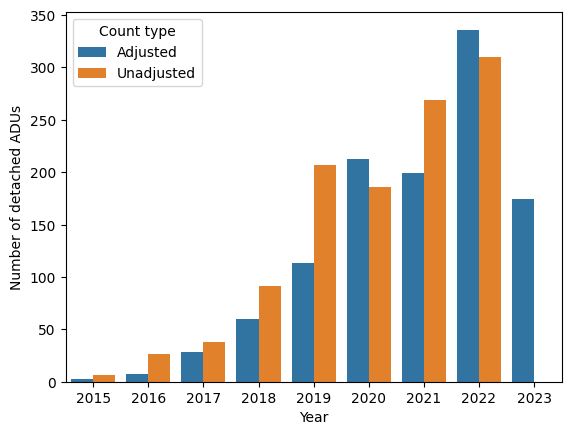

In [118]:
plt.clf()
ax = sns.barplot(annual_counts, x='year', y='Count', hue='Count type')
ax.set(xlabel='Year', ylabel='Number of detached ADUs')
plt.show()

In [119]:
# 2016-2020 additions
annual_counts.loc[annual_counts['year'].isin([2016, 2017, 2018, 2019, 2020])].groupby(
    'Count type')['Count'].sum().reset_index()

,Count type,Count
0,Adjusted,421
1,Unadjusted,548
